In [1]:
import jax.numpy as jnp
import numpy as np
import jax
jax.config.update("jax_enable_x64", True)
from astropy.io import fits
import tqdm

from matplotlib import rc
import matplotlib.pyplot as plt
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
import cmasher as cm

import load_data as ld
import optimise as opt
import scatters as opt_sc
import init_latents as il
import kfold_cv as kf


In [2]:
file_name = '-test-rgbs-openclusters'
spectra_dir_path = '../spec/spectra-reference-stars-APOGEE-open-clusters/'
file_path = '../data/master-APOGEE-open-clusters-withnames.fits'
spectra_data, label_data = ld.load_data(spectra_dir_path, file_path, file_name)

../spec/spectra-reference-stars-APOGEE-open-clusters/spectra_data-test-rgbs-openclusters.dat
File already exists. Loading spectra data


24it [00:00, 80.74it/s]

Loaded data successfully


In [3]:
n = 5000
test_ID = label_data['ids'][:n]
test_flux = spectra_data['fluxes'][:n]
test_flux_err = spectra_data['fluxes_err'][:n]
test_flux_ivar = spectra_data['fluxes_ivars'][:n]
test_label = label_data['labels'][:n]
test_label_err = label_data['labels_err'][:n]
test_label_ivar = label_data['labels_ivars'][:n]

In [4]:
l2reg = 1000
latent_dim = 'P49'
savepath = '../sav/paper/'
name = '_'+str(latent_dim)+'_L2regstrength'+str(l2reg)+'_omega1-train-highsnrgiants'
alphas = np.load(savepath+'alphas_giants-withscatters'+str(name)+'.npy', allow_pickle=True)
betas = np.load(savepath+'betas_giants-withscatters'+str(name)+'.npy', allow_pickle=True)
zetas = np.load(savepath+'zetas_train_giants-withscatters'+str(name)+'.npy', allow_pickle=True)
ln_noise_fluxes_updated = jnp.log(np.load(savepath+'noise_fluxes_train_giants-withscatters'+str(name)+'.npy', allow_pickle=True))


In [5]:
P = 49
alphas_init_test, betas_init_test, zetas_init_test = il.initialise_alphas_betas_zetas(test_label, test_flux, P)

In [6]:
res_zetas_fromfluxes = opt_sc.get_zetas_test_using_fluxes(test_flux, test_flux_ivar, betas, zetas_init_test, ln_noise_fluxes_updated)
zetas_test_fromfluxes = res_zetas_fromfluxes.params['zetas']

INFO: jaxopt.ZoomLineSearch: Iter: 30, Stepsize: 1.862645149230957e-06, Decrease error: 5052458916496.99, Curvature error: 5.425454056712413e+18


In [7]:
labels_test_fromflux = zetas_test_fromfluxes @ alphas.T
spectra_test_fromflux = zetas_test_fromfluxes @ betas.T

In [8]:
savepath = '../sav/paper/'
name = '_49_L2regstrength1000_omega1-train-openclustergiants'
np.save(savepath+'zetas_test_fromflux_giants-withscatters'+str(name), zetas_test_fromfluxes)
np.save(savepath+'labels_test_fromflux_giants-withscatters'+str(name), labels_test_fromflux)
np.save(savepath+'spectra_test_fromflux_giants-withscatters'+str(name), spectra_test_fromflux)


In [5]:
savepath = '../sav/paper/'
name = '_49_L2regstrength1000_omega1-train-openclustergiants'
zetas_test_fromfluxes = np.load(savepath+'zetas_test_fromflux_giants-withscatters'+str(name)+'.npy', allow_pickle=True)
labels_test_fromflux = np.load(savepath+'labels_test_fromflux_giants-withscatters'+str(name)+'.npy', allow_pickle=True)
spectra_test_fromflux = np.load(savepath+'spectra_test_fromflux_giants-withscatters'+str(name)+'.npy', allow_pickle=True)

In [6]:
# LOAD THE DATA
tb = fits.open('../data/master-APOGEE-open-clusters-withnames.fits')
data = tb[1].data 
print(len(data))

5000


In [7]:
names_gc = ['NGC 188', 'FSR 0496', 'FSR 0542', 'NGC 752', 'IC 166', 'Collinder 34', 'Berkeley 66', 'ASCC 11', 'NGC 1857']
colores = ['firebrick', 'red', 'hotpink', 'indigo', 'b', 'cyan', 'darkgreen', 'limegreen', 'lime']

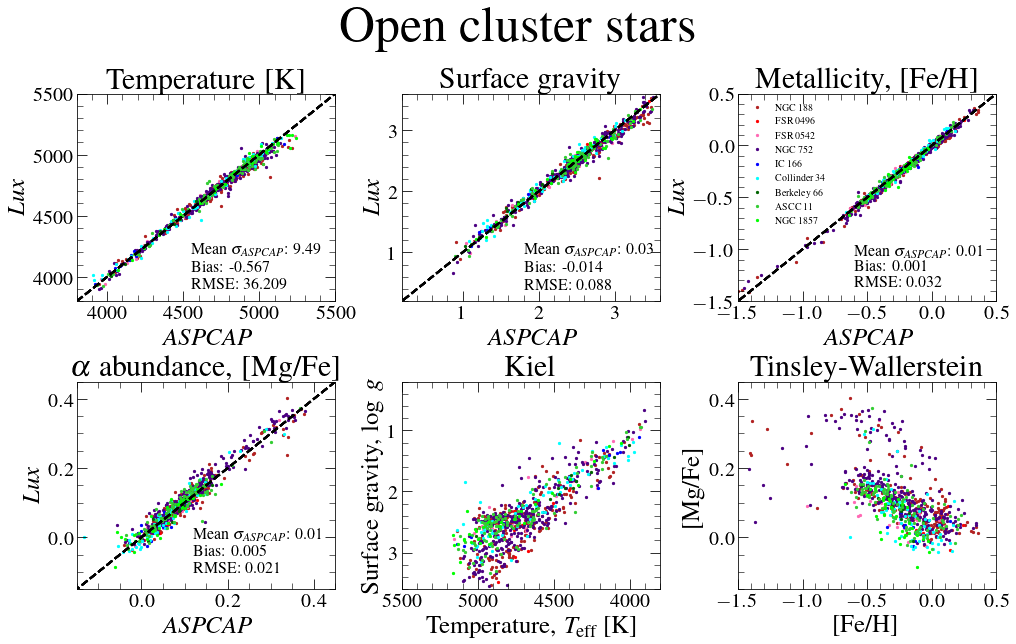

In [9]:
fig = plt.figure(figsize=(14,8), constrained_layout=True)
fig.suptitle(r'Open cluster stars',fontsize=50,x=0.51,y=1.1)

for indx, i in enumerate(names_gc):

    
    mask = data['CLUSTER'][:n]==i
    plt.subplot(2,3,1)
    # plt.title('$T_{\mathrm{eff}}$', fontsize=30)
    plt.title('Temperature [K]', fontsize=30)
    plt.plot([3800,5500], [3800,5500], color='k',alpha=0.8, lw=2, ls='--')
    color = plt.scatter(test_label[:,0][mask], labels_test_fromflux[:,0][mask], s=5, rasterized=True, c=colores[indx], label=str(i))
    plt.xlim(3800,5500)
    plt.ylim(3800,5500)
    plt.xlabel(r'$ASPCAP$', fontsize=25)
    plt.ylabel(r'$Lux$', fontsize=25)
    plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
    plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
    plt.minorticks_on()

    plt.subplot(2,3,2)
    plt.title('Surface gravity', fontsize=30)
    plt.plot([0,3.6],[0,3.6], color='k',alpha=0.8, lw=2, ls='--')
    plt.scatter(test_label[:,1][mask], labels_test_fromflux[:,1][mask], s=5, rasterized=True, c=colores[indx])

    plt.xlim(0.2,3.6)
    plt.ylim(0.2,3.6)
    plt.xlabel(r'$ASPCAP$', fontsize=25)
    plt.ylabel(r'$Lux$', fontsize=25)
    plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
    plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
    plt.minorticks_on()

    plt.subplot(2,3,3)
    plt.title('Metallicity, [Fe/H]', fontsize=30)
    plt.plot([-2,0.5], [-2,0.5], color='k',alpha=0.8, lw=2, ls='--')
    plt.scatter(test_label[:,2][mask], labels_test_fromflux[:,2][mask], s=5, rasterized=True, c=colores[indx], label=str(i))
    plt.legend(frameon=False, ncols=1, fontsize=10, loc='upper left')
    plt.xlim(-1.5,0.5)
    plt.ylim(-1.5,0.5)
    plt.ylabel(r'$Lux$', fontsize=25)
    plt.xlabel(r'$ASPCAP$', fontsize=25)
    plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
    plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
    plt.minorticks_on()

    plt.subplot(2,3,4)
    plt.title(r'$\alpha$ abundance, [Mg/Fe]', fontsize=30)
    plt.plot([-0.6,0.6], [-0.6,0.6], color='k',alpha=0.8, lw=2, ls='--')
    plt.scatter(test_label[:,6][mask], labels_test_fromflux[:,6][mask], s=5, rasterized=True, c=colores[indx])
    plt.xlim(-0.15,0.45)
    plt.ylim(-0.15,0.45)
    plt.xlabel(r'$ASPCAP$', fontsize=25)
    plt.ylabel(r'$Lux$', fontsize=25)
    plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
    plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
    plt.minorticks_on()

    plt.subplot(2,3,5)
    plt.title('Kiel', fontsize=30)
    plt.scatter(labels_test_fromflux[:,0][mask], labels_test_fromflux[:,1][mask], s=5, rasterized=True, c=colores[indx])

    plt.xlim(5500, 3800)
    plt.ylim(3.6, 0.2)
    plt.xlabel(r'Temperature, $T_{\mathrm{eff}}$ [K]', fontsize=25)
    plt.ylabel(r'Surface gravity, $\log~g$', fontsize=25)
    plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
    plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
    plt.minorticks_on()

    plt.subplot(2,3,6)
    plt.title('Tinsley-Wallerstein', fontsize=30)
    plt.scatter(labels_test_fromflux[:,2][mask], labels_test_fromflux[:,6][mask], s=5, rasterized=True, c=colores[indx])

    plt.xlim(-1.5,0.5)
    plt.ylim(-0.15,0.45)
    plt.xlabel(r'[Fe/H]', fontsize=25)
    plt.ylabel(r'[Mg/Fe]', fontsize=25)
    plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
    plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
    plt.minorticks_on()

plt.subplot(2,3,1)
plt.text(4550,3900, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(test_label)*(jnp.nansum((test_label[:n,0]-labels_test_fromflux[:,0])**2))))), fontsize=16)
plt.text(4550,4050, 'Bias: '+str("{:.3f}".format(jnp.mean(test_label[:n,0]-labels_test_fromflux[:,0]))), fontsize=16)
plt.text(4550,4200, 'Mean $\sigma_{ASPCAP}$: '+str("{:.2f}".format(jnp.mean(test_label_err[:n,0]))), fontsize=16)

plt.subplot(2,3,2)
plt.text(1.8,0.4, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(test_label)*(jnp.nansum((test_label[:n,1]-labels_test_fromflux[:,1])**2))))), fontsize=16)
plt.text(1.8,0.7, 'Bias: '+str("{:.3f}".format(jnp.mean(test_label[:n,1]-labels_test_fromflux[:,1]))), fontsize=16)
plt.text(1.8,1, 'Mean $\sigma_{ASPCAP}$: '+str("{:.2f}".format(jnp.mean(test_label_err[:n,1]))), fontsize=16)

plt.subplot(2,3,3)
plt.text(-0.6,-1.35, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(test_label)*(jnp.nansum((test_label[:n,2]-labels_test_fromflux[:,2])**2))))), fontsize=16)
plt.text(-0.6,-1.2, 'Bias: '+str("{:.3f}".format(jnp.mean(test_label[:n,2]-labels_test_fromflux[:,2]))), fontsize=16)
plt.text(-0.6,-1.05, 'Mean $\sigma_{ASPCAP}$: '+str("{:.2f}".format(jnp.mean(test_label_err[:n,2]))), fontsize=16)

plt.subplot(2,3,4)
plt.text(0.12,-0.1, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(test_label)*(jnp.nansum((test_label[:n,6]-labels_test_fromflux[:,6])**2))))), fontsize=16)
plt.text(0.12,-0.05, 'Bias: '+str("{:.3f}".format(jnp.mean(test_label[:n,5]-labels_test_fromflux[:,6]))), fontsize=16)
plt.text(0.12,0, 'Mean $\sigma_{ASPCAP}$: '+str("{:.2f}".format(jnp.mean(test_label_err[:n,6]))), fontsize=16)


plt.savefig('../plots/paper/openclusters-lux.pdf',dpi=200, bbox_inches = 'tight')